# Dataset exploration, ECG Hearthbeat
Notebook source: https://www.kaggle.com/code/gregoiredc/arrhythmia-on-ecg-classification-using-cnn/notebook

Kaggle dataset: https://www.kaggle.com/datasets/shayanfazeli/heartbeat

dataset source: https://physionet.org/content/mitdb/1.0.0/

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

In [3]:
train_df = pd.read_csv(os.path.join(path, "mitbih_train.csv"), header=None)
test_df = pd.read_csv(os.path.join(path, "mitbih_test.csv"), header=None)

Train shape:  (87554, 188)
Test shape:  (21892, 188)


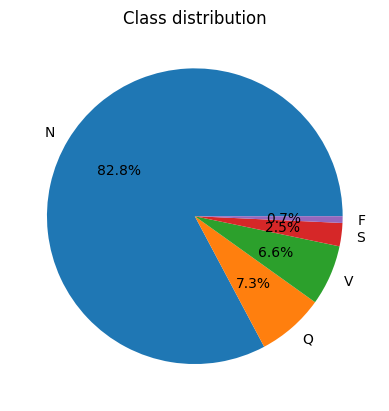

In [4]:
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)
classes=train_df[187].astype(int).value_counts()
plt.title("Class distribution")
plt.pie(classes, labels=["N", "Q", "V", "S", "F"], autopct='%1.1f%%')
plt.show()

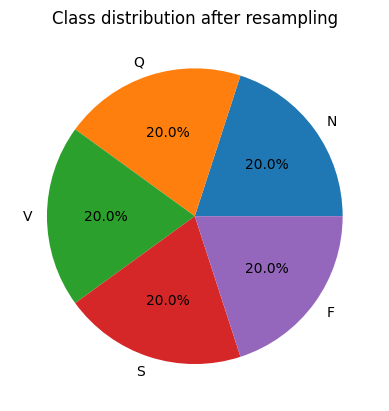

In [5]:


from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

classes=train_df[187].astype(int).value_counts()
plt.title("Class distribution after resampling")
plt.pie(classes, labels=["N", "Q", "V", "S", "F"], autopct='%1.1f%%')
plt.show()

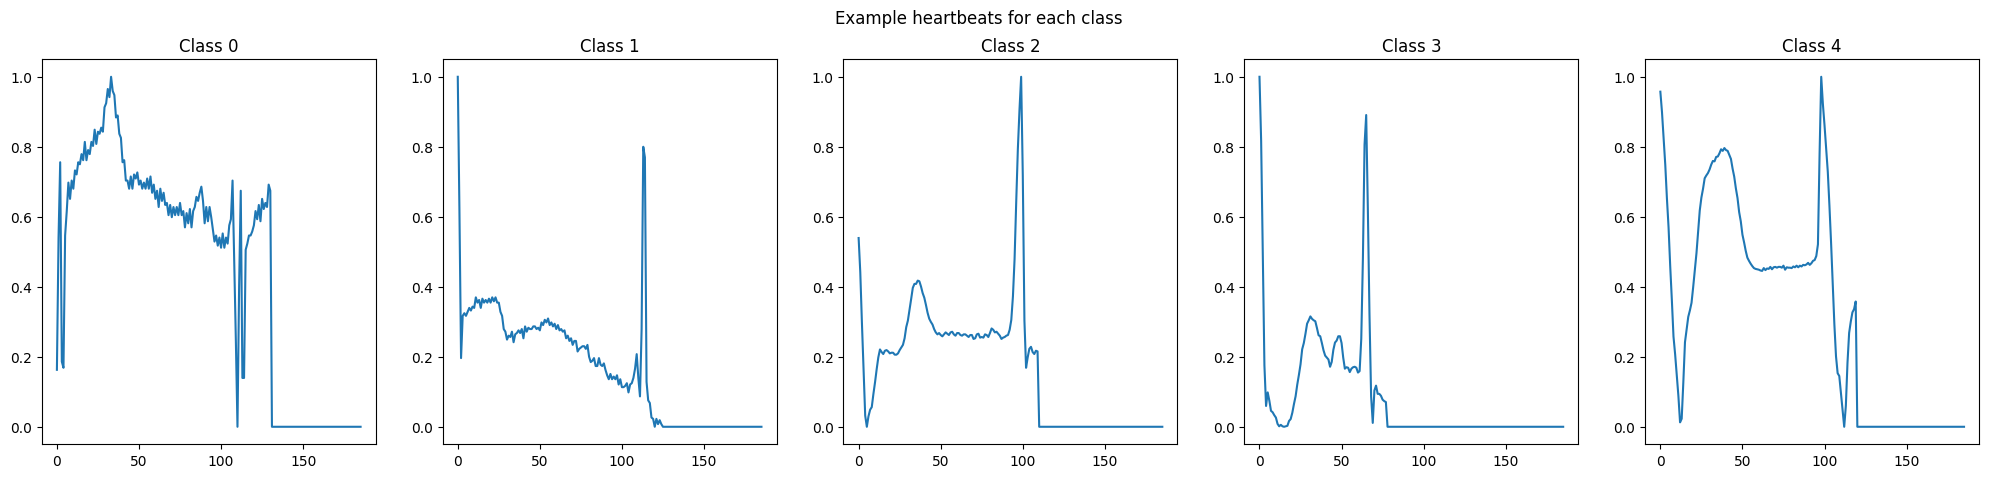

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle("Example heartbeats for each class")
axs = axs.ravel()
for c in range(5):
    axs[c].set_title("Class "+str(c))
    axs[c].plot(train_df[train_df[187]==c].values[0, :186])
plt.show()

In [8]:
import torch
from torch.nn import Conv1d, MaxPool1d, BatchNorm1d, ReLU, Linear, Softmax

class BaselineCNN(torch.nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.cnn1 = Conv1d(in_channels=1, out_channels=64, kernel_size=6)
        self.batch_norm1 = BatchNorm1d(num_features=64)
        self.max_pool1 = MaxPool1d(kernel_size=3, stride=2)

        self.cnn2 = Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.batch_norm2 = BatchNorm1d(num_features=64)
        self.max_pool2 = MaxPool1d(kernel_size=2, stride=2)

        self.cnn3 = Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.batch_norm3 = BatchNorm1d(num_features=64)
        self.max_pool3 = MaxPool1d(kernel_size=2, stride=2)
        
        self.act = ReLU()

        self.lin1 = Linear(64*21, 64)
        self.lin2 = Linear(64, 32)
        self.lin3 = Linear(32, 5)

        self.softmax = Softmax()
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.batch_norm1(x)
        x = self.act(x)
        x = self.max_pool1(x)

        x = self.cnn2(x)
        x = self.batch_norm2(x)
        x = self.act(x)
        x = self.max_pool2(x)

        x = self.cnn3(x)
        x = self.batch_norm3(x)
        x = self.max_pool3(x)

        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.act(x)

        x = self.lin2(x)
        x = self.act(x)

        x = self.lin3(x)
        x = self.softmax(x)
        return x


model = BaselineCNN()

In [12]:
class BaselineCNN2(torch.nn.Module):
    def __init__(self):
        super(BaselineCNN2, self).__init__()
        self.layer_norm = torch.nn.LayerNorm((1, 186))
        self.cnn1 = Conv1d(in_channels=1, out_channels=64, kernel_size=6)
        #self.batch_norm1 = BatchNorm1d(num_features=64)

        self.cnn2 = Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        #self.batch_norm2 = BatchNorm1d(num_features=64)

        self.cnn3 = Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        #self.batch_norm3 = BatchNorm1d(num_features=64)
        
        self.act = ReLU()

        self.lin1 = Linear(11328, 64)
        self.lin2 = Linear(64, 32)
        self.lin3 = Linear(32, 5)

        self.softmax = Softmax()
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.cnn1(x)
        x = self.act(x)

        x = self.cnn2(x)
        x = self.act(x)

        x = self.cnn3(x)
        x = self.act(x)

        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.act(x)

        x = self.lin2(x)
        x = self.act(x)

        x = self.lin3(x)
        x = self.softmax(x)
        return x
model = BaselineCNN2()

In [13]:
class BasicCNN(torch.nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.cnn1 = Conv1d(in_channels=1, out_channels=16, kernel_size=6)

        self.cnn2 = Conv1d(in_channels=16, out_channels=16, kernel_size=3)

        self.cnn3 = Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        
        self.act = ReLU()

        self.lin1 = Linear(2832, 16)
        self.lin2 = Linear(16, 8)
        self.lin3 = Linear(8, 5)

        self.softmax = Softmax()
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.act(x)

        x = self.cnn2(x)
        x = self.act(x)

        x = self.cnn3(x)
        x = self.act(x)

        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.act(x)

        x = self.lin2(x)
        x = self.act(x)

        x = self.lin3(x)
        x = self.softmax(x)
        return x
model = BasicCNN()

In [14]:
class CirculantLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(CirculantLayer, self).__init__()
        self._weights = torch.nn.Parameter(torch.randn(out_features, 1))
        self.weights = torch.cat([self._weights.roll(shifts=i, dims=0) for i in range(in_features)], dim=1)
        self.bias = torch.nn.Parameter(torch.randn(out_features))
    def forward(self, x):
        return  x @ self.weights + self.bias

class WideConvs(torch.nn.Module):
    def __init__(self):
        super(WideConvs, self).__init__()
        #self.cnn1 = Conv1d(in_channels=1, out_channels=1, kernel_size=186, padding_mode="circular")
        self.cnn1 = CirculantLayer(186, 186)
        self.cnn2 = CirculantLayer(186, 186)
        self.cnn3 = CirculantLayer(186, 186)

        #self.cnn2 = Conv1d(in_channels=1, out_channels=1, kernel_size=186, padding_mode="circular")

        #self.cnn3 = Conv1d(in_channels=1, out_channels=1, kernel_size=186, padding_mode="circular")
        
        self.act = ReLU()

        self.lin1 = Linear(186, 16)
        self.lin2 = Linear(16, 16)
        self.lin3 = Linear(16, 5)

        self.softmax = Softmax()
    
    def forward(self, x):
        #x = x.transpose(1,2)
        x = x.squeeze(1)
        x = self.cnn1(x)
        x = self.act(x)

        x = self.cnn2(x)
        x = self.act(x)

        x = self.cnn3(x)
        x = self.act(x)

        #x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.act(x)

        x = self.lin2(x)
        x = self.act(x)

        x = self.lin3(x)
        x = self.softmax(x)
        return x
model = WideConvs()

In [9]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lin1 = Linear(186, 8)
        self.lin2 = Linear(8, 8)
        self.lin3 = Linear(8, 5)

        self.act = ReLU()
        self.softmax = Softmax()

    def forward(self, x):
        x = x.squeeze(1)
        x = self.lin1(x)
        x = self.act(x)

        x = self.lin2(x)
        x = self.act(x)

        x = self.lin3(x)
        x = self.softmax(x)
        return x 
model = NN()


In [10]:
def validate(model, X_val, y_val):
    y_pred = model(X_val)
    predicted = torch.argmax(y_pred.data, 1)
    correct = (predicted == y_val).sum().item()
    print(f"Validation accuracy: {correct/len(y_val)}")

In [11]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
dataloader = torch.utils.data.DataLoader(torch.tensor(train_df.values), batch_size=64, shuffle=True)
n_epochs = 10
for epoch in range(n_epochs):
    model.eval()
    validate(model, torch.tensor(test_df.values[:, :186]).unsqueeze(1).float(), torch.tensor(test_df.values[:, 187]))
    model.train()
    for i, batch in enumerate(dataloader):
        optim.zero_grad()
        X = batch[:, :186].unsqueeze(1)
        y = batch[:, 187]
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y.long(), num_classes=5)
        loss = loss_fn(y_pred, y.double())
        loss.backward()
        optim.step()
    print("Epoch: ", epoch, "Loss: ", loss.item())

/home/rasmuslovstad/Programs/assignments/thesis/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation accuracy: 0.06614288324502102
Epoch:  0 Loss:  1.2545798234641552
Validation accuracy: 0.6223734697606431
Epoch:  1 Loss:  1.2472095116972923
Validation accuracy: 0.6791978805042939
Epoch:  2 Loss:  1.0631494037806988
Validation accuracy: 0.735108715512516
Epoch:  3 Loss:  1.0578244868665934
Validation accuracy: 0.730358121688288
Epoch:  4 Loss:  1.1003718115389347
Validation accuracy: 0.7393568426822583
Epoch:  5 Loss:  1.1216804552823305
Validation accuracy: 0.7507308605883428
Epoch:  6 Loss:  1.1545002106577158
Validation accuracy: 0.7542481271697423
Epoch:  7 Loss:  0.9714696891605854
Validation accuracy: 0.7754430842316828
Epoch:  8 Loss:  1.0387193765491247
Validation accuracy: 0.7689110177233692
Epoch:  9 Loss:  1.177298242226243


In [12]:
model.eval()
test_X = torch.tensor(test_df.values[:, :186]).unsqueeze(1).float()
test_y = torch.tensor(test_df.values[:, 187])
y_pred = torch.argmax(model(test_X), 1)
print("Test accuracy: ", (y_pred == test_y).sum().item()/len(test_y))


Test accuracy:  0.7831627991960534


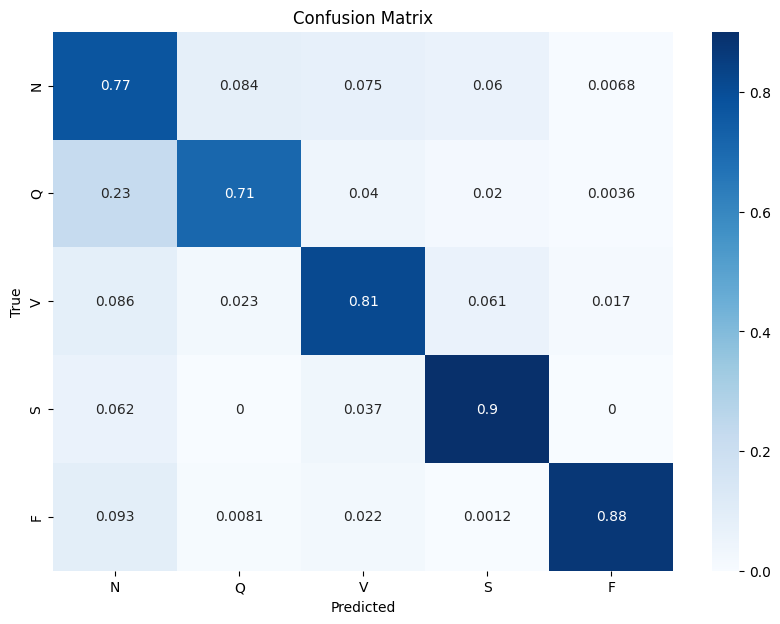

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=["N", "Q", "V", "S", "F"], yticklabels=["N", "Q", "V", "S", "F"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [51]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 113861


In [98]:
(50*50 + 50) + (1*50 + 50) + (50*1 + 1)

2701

(None, None)
(None,)
(None, None)
(None,)
(None, None)
(None,)
